In [2]:
import sys
import dill
import importlib

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../src')
import policies 
import bbDebiasing
import maxEnsembleDebias

sys.path.append('experiment-pipeline')
import analysisHelp
import dataGeneration

Comparison of final WB and BB Models

In [3]:
importlib.reload(analysisHelp)

pathA = ['linear-label_gb_coord_variance_5000_subsample400_BBModel.pkl',
'linear-label_gb_coord_variance_5000_subsample400_MaxEnsemble.pkl']
pathB = ['linear-label_gb_group_variance_5000_subsample400_BBModel.pkl',
'linear-label_gb_group_variance_5000_subsample400_MaxEnsemble.pkl']
pathC = ['linear-label_gb_coord_linear-constraint_5000_subsample400_BBModel.pkl',
'linear-label_gb_coord_linear-constraint_5000_subsample400_MaxEnsemble.pkl']
pathD = ['linear-label_gb_group_linear-constraint_8000_subsample400_BBModel.pkl',
'linear-label_gb_group_linear-constraint_8000_subsample400_MaxEnsemble.pkl']

pathsets = [pathA, pathB, pathC, pathD]
experimentNames = ["A","B","C","D"]



In [ ]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]
# Update the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, axs = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(12, 8))
fig.tight_layout(pad=4.0)  # Use tight_layout for better spacing

for i in range(len(pathsets)):

    bbPath = f'experiment-pipeline/debiased-models/{pathsets[i][0]}'
    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(bbPath, 'rb') as file:
        bbModel = dill.load(file)
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)

    BBpred_rev = np.mean(np.sum(np.multiply(bbModel.predictions_by_round, np.array(bbModel.policy_by_round)), axis=2), axis=1)
    BBreal_rev = np.mean(np.sum(np.multiply(np.tile(bbModel.train_y, (len(bbModel.policy_by_round),1,1)), np.array(bbModel.policy_by_round)), axis=2), axis=1)
    #maxEnsemblereal_rev = np.mean(np.array(maxModel.realized_revs_by_round), axis=2)
    meta_real_rev = []
    meta_pred_rev = []
    for j in range(maxModel.curr_depth):
        meta_real_rev.append(np.mean(maxModel.realized_revs_by_round[j][maxModel.max_policy_index_by_round[j], np.arange(maxModel.n)]))
        meta_pred_rev.append(np.mean(maxModel.self_assessed_revs_by_round[j][maxModel.max_policy_index_by_round[j], np.arange(maxModel.n)]))

    max_init_model = np.max(np.mean(maxModel.realized_revs_by_round[0], axis=1))

    if i==0:
        axs[i//2,i%2].hlines(max_init_model, 0, maxModel.curr_depth-1, label=f"Realized Payoff of Best Initial Policy", color=colors[0])
        axs[i//2,i%2].hlines(np.mean(np.einsum('ij, ij->i', maxModel.train_y, maxModel.policies[0].run_given_preds(maxModel.train_y))), 0, maxModel.curr_depth-1, label="Optimal Payoff (Labels Known)", color=colors[3])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_real_rev, label=f"Realized Payoff of White-Box Alg", color=colors[6])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_pred_rev, '--', label=f"Predicted Payoff of White-Box Alg", color=colors[6])
        axs[i//2,i%2].plot(np.arange(len(BBreal_rev[:-1])), BBreal_rev[:-1], label="Realized Payoff of Black-Box Policy", color=colors[8])
        axs[i//2,i%2].plot(np.arange(len(BBpred_rev[:-1])), BBpred_rev[:-1], '--', label="Predicted Payoff of Black-Box Alg", color=colors[8])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)
        
    else:
        axs[i//2,i%2].hlines(max_init_model, 0, maxModel.curr_depth-1, color=colors[0])
        axs[i//2,i%2].hlines(np.mean(np.einsum('ij, ij->i', maxModel.train_y, maxModel.policies[0].run_given_preds(maxModel.train_y))), 0, maxModel.curr_depth-1, color=colors[3])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_real_rev, color=colors[6])
        axs[i//2,i%2].plot(np.arange(maxModel.curr_depth), meta_pred_rev, '--', color=colors[6])
        axs[i//2,i%2].plot(np.arange(len(BBreal_rev[:-1])), BBreal_rev[:-1], color=colors[8])
        axs[i//2,i%2].plot(np.arange(len(BBpred_rev[:-1])), BBpred_rev[:-1], '--', color=colors[8])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)

axs[0,0].set_ylabel('Payoff', fontsize=10)
axs[1,0].set_ylabel('Payoff', fontsize=10)
axs[1,0].set_xlabel('Debiasing Rounds', fontsize=10)
axs[1,1].set_xlabel('Debiasing Rounds', fontsize=10)

fig.suptitle("Comparison of Payoffs of White-Box and Black Box Algorithms", fontsize=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(top=0.9, bottom=0.17) 
fig.legend(loc='lower center', ncol=3)
plt.savefig('paper-figs/WBvsBB.pdf')

Looking at White Box Alg internals

In [ ]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]
# Update the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(12, 8))
fig.tight_layout(pad=4.0)  # Use tight_layout for better spacing

for i in range(len(pathsets)):

    bbPath = f'experiment-pipeline/debiased-models/{pathsets[i][0]}'
    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(bbPath, 'rb') as file:
        bbModel = dill.load(file)
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)

    pred_rev = np.mean(np.array(maxModel.self_assessed_revs_by_round), axis=2)
    real_rev = np.mean(np.array(maxModel.realized_revs_by_round), axis=2)
    max_init_model = max([real_rev[0,i] for i in range(maxModel.n_models)])
    n = len(maxModel.self_assessed_revs_by_round)

    if i==1:
        axs[i//2,i%2].hlines(np.mean(np.einsum('ij, ij->i', maxModel.train_y, maxModel.policies[0].run_given_preds(maxModel.train_y))), 0, n-1, label="Optimal Payoff (Labels Known)", color=colors[0])
        axs[i//2,i%2].hlines(max_init_model, 0, maxModel.curr_depth-1, label=f"Realized Payoff of Best Initial Policy", color=colors[3])
        for j in range(maxModel.n_models):
            axs[i//2,i%2].plot(np.arange(n), real_rev[:,j], label=f"Realized Payoff: Policy {j}", color=colors[5+j])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)
        
    else:
        axs[i//2,i%2].hlines(np.mean(np.einsum('ij, ij->i', maxModel.train_y, maxModel.policies[0].run_given_preds(maxModel.train_y))), 0, n-1, color=colors[0])
        axs[i//2,i%2].hlines(max_init_model, 0, maxModel.curr_depth-1, color=colors[3])
        for j in range(maxModel.n_models):
            axs[i//2,i%2].plot(np.arange(n), real_rev[:,j], color=colors[5+j])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)

axs[0,0].set_ylabel('Payoff', fontsize=10)
axs[1,0].set_ylabel('Payoff', fontsize=10)
axs[1,0].set_xlabel('Debiasing Rounds', fontsize=10)
axs[1,1].set_xlabel('Debiasing Rounds', fontsize=10)

fig.suptitle("Payoffs of Component Policies of White Box Ensemble", fontsize=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(top=0.9, bottom=0.17) 
fig.legend(loc='lower center', ncol=4)
plt.savefig('paper-figs/WBComponentPolicies.pdf')

Comparison of use of feature space

In [ ]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]
# Update the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(12, 8))
fig.tight_layout(pad=4.0)  # Use tight_layout for better spacing

for i in range(len(pathsets)):

    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)
    
    max_policies = np.array(maxModel.max_policy_index_by_round)
   
    #cbar = plt.colorbar(label='Times Policy Used')

    if i==0 or i==2:
        hist_over_rounds = np.apply_along_axis(lambda row: np.histogram(row, bins=4)[0], axis=1, arr=max_policies)
        cmap = plt.get_cmap('viridis')
        im = axs[i//2,i%2].imshow(hist_over_rounds, 
                cmap=cmap, aspect='auto', origin='lower', interpolation='Nearest')
        axs[i//2,i%2].set_xticks(ticks=np.arange(0,4,0.5), labels=['Policy 0','', 'Policy 1','', 'Policy 2','', 'Policy 3',''])
        axs[i//2,i%2].vlines([0.5,1.5,2.5],0, 4999, color='white')  
    if i==1 or i==3:
        hist_over_rounds = np.apply_along_axis(lambda row: np.histogram(row, bins=5)[0], axis=1, arr=max_policies)
        cmap = plt.get_cmap('viridis')
        im = axs[i//2,i%2].imshow(hist_over_rounds, 
                cmap=cmap, aspect='auto', origin='lower', interpolation='Nearest')
        axs[i//2,i%2].set_xticks(ticks=np.arange(0,5,0.5), labels=['Policy 0','', 'Policy 1','', 'Policy 2','', 'Policy 3','', 'Policy 4',''])
        axs[i//2,i%2].vlines([0.5,1.5,2.5],0, 4999, color='white')  
    if i==3:
        axs[i//2,i%2].vlines([0.5,1.5,2.5],0, 7999, color='white')  
    axs[i//2,i%2].grid(False)
    axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)
     

axs[0,0].set_ylabel('Round of Debiasing', fontsize=10)
axs[1,0].set_ylabel('Round of Debiasing', fontsize=10)
axs[1,0].set_xlabel('Policy Chosen', fontsize=10)
axs[1,1].set_xlabel('Policy Chosen', fontsize=10)

fig.suptitle('Policy Used by White Box Ensemble Policy Over Rounds of Debiasing', fontsize=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(top=0.9, bottom=0.17) 
cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Times Policy Used')
plt.savefig('paper-figs/WBPolicyChosen.pdf',dpi=fig.dpi)





In [ ]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]
# Update the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(12, 8))
fig.tight_layout(pad=4.0)  # Use tight_layout for better spacing

for i in range(len(pathsets)):
    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)

    if i==0 or i==2:
        axs[i//2, i%2].bar(['Policy 0', 'Policy 1', 'Policy 2', 'Policy 3'],np.unique(maxModel.max_policy_index_by_round[-1], return_counts=True)[1])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)
    else:
        axs[i//2, i%2].bar(['Policy 0', 'Policy 1', 'Policy 2', 'Policy 3', 'Policy 4'],np.unique(maxModel.max_policy_index_by_round[-1], return_counts=True)[1])
        axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)

axs[0,0].set_ylabel('Times Policy Used', fontsize=10)
axs[1,0].set_ylabel('Times Policy Used', fontsize=10)
axs[1,0].set_xlabel('Policy Chosen', fontsize=10)
axs[1,1].set_xlabel('Policy Chosen', fontsize=10)

fig.suptitle("Payoffs of Component Policies of White Box Ensemble", fontsize=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(top=0.9, bottom=0.17) 
plt.savefig('paper-figs/FinalRoundHistograms.pdf')

In [ ]:
data = np.array(maxModel.policies_by_round)
data.shape

In [ ]:
np.mean(np.var(np.array(maxModel.policies_by_round)[0], axis=0))
#np.mean(np.var(np.array(maxModel.policies_by_round)[0], axis=0))

In [ ]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]
# Update the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, axs = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(12, 8))
fig.tight_layout(pad=4.0)  # Use tight_layout for better spacing

for i in range(len(pathsets)):
    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)

    out = np.zeros(len(maxModel.policies_by_round))
    for j in range(len(maxModel.policies_by_round)):
        out[j] = np.mean(np.var(maxModel.policies_by_round[j], axis=0))

    axs[i//2, i%2].plot(out)
    axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)

axs[0,0].set_ylabel('Average Variance Between Policies', fontsize=10)
axs[1,0].set_ylabel('Average Variance Between Policies', fontsize=10)
axs[1,0].set_xlabel('Round of Debiasing', fontsize=10)
axs[1,1].set_xlabel('Round of Debiasing', fontsize=10)

fig.suptitle("Variance Between Component Policies of White Box Ensemble", fontsize=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(top=0.9, bottom=0.17) 
plt.savefig('paper-figs/WBvariance.pdf')

In [ ]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]
# Update the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(12, 8))
fig.tight_layout(pad=4.0)  # Use tight_layout for better spacing

for i in range(len(pathsets)):

    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(wbPath, 'rb') as file:
        maxModel = dill.load(file)
    
    max_policies = np.array(maxModel.max_policy_index_by_round)
   
    out = np.zeros((len(maxModel.policies_by_round), 400))
    for j in range(len(maxModel.policies_by_round)):
        out[j] = np.sort(np.mean(np.var(maxModel.policies_by_round[j], axis=0), axis=1))

    cmap = plt.get_cmap('viridis')
    im = axs[i//2,i%2].imshow(out, 
                    cmap=cmap, aspect='auto', origin='lower', interpolation='Nearest')
    axs[i//2,i%2].grid(False)
    axs[i//2,i%2].set_title(f'Experiment {experimentNames[i]}', fontsize=12)     

axs[0,0].set_ylabel('Round of Debiasing', fontsize=10)
axs[1,0].set_ylabel('Round of Debiasing', fontsize=10)
axs[1,0].set_xlabel('Datapoints (Sorted by Average Variance of Policies)', fontsize=10)
axs[1,1].set_xlabel('Datapoints (Sorted by Average Variance of Policies)', fontsize=10)

fig.suptitle("Average Variance in White Box Algorithm's Constituent Policies by \n Datapoint Over Rounds of Debiasing", fontsize=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(top=0.85, bottom=0.17) 
cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Average Variance Across Constituent Policies for Datapoint')
plt.savefig('paper-figs/AverageVarianceHeatmap.pdf',dpi=fig.dpi)



# out = np.zeros((len(maxModel.policies_by_round), 400))
# for j in range(len(maxModel.policies_by_round)):
#     out[j] = np.sort(np.mean(np.var(maxModel.policies_by_round[j], axis=0), axis=1))

# plt.imshow(out, 
#                 cmap=cmap, aspect='auto', origin='lower', interpolation='Nearest')
# plt.grid(False)
# cbar = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.1)
# cbar.set_label('Average Variance Across Policies for Datapoint')


# Out of Sample Results

In [55]:
# Get out-of-sample results
main_path = 'experiment-pipeline/out-of-sample'
experimentNames = ['A', 'B', 'C', 'D']

bbPreds_oos, wbPreds_oos, wbPredPayoff_oos, wbRealPayoff_oos, bbPredPayoff_oos, bbRealPayoff_oos = [],[],[],[],[],[]
max_init_oos = []
for i in range(len(experimentNames)):
    path = f"{main_path}/{experimentNames[i]}"
    wbPredPayoff_oos.append(np.load(f"{path}/wbPredPayoff.npy"))
    wbRealPayoff_oos.append(np.load(f"{path}/wbRealPayoff.npy"))
    bbPredPayoff_oos.append(np.load(f"{path}/bbPredPayoff.npy"))
    bbRealPayoff_oos.append(np.load(f"{path}/bbRealPayoff.npy"))
    
    with open(f"{path}/bbTranscript.pkl", 'rb') as file:
        bbTranscript = dill.load(file)
    with open(f"{path}/wbTranscript.pkl", 'rb') as file:
        wbTranscript = dill.load(file)

    data_path = '../data/synthetic'
    test_y = np.loadtxt(f"{data_path}/linear-labels_test.csv", delimiter=',')

    max_init_oos.append(np.mean(np.sum(np.multiply(wbTranscript.meta_policy_choice_by_round[0], test_y), axis=1)))

# Get in-sample results
# Final round
bbPredPayoff_is, bbRealPayoff_is, wbPredPayoff_is, wbRealPayoff_is = [],[],[],[]
# Initial round best payoff and best payoff when labels known
max_init_is, best_is, best_oos = [],[],[]
# now get equivalent numbers in sample
for i in range(len(experimentNames)):
    bbPath = f'experiment-pipeline/debiased-models/{pathsets[i][0]}'
    wbPath = f'experiment-pipeline/debiased-models/{pathsets[i][1]}'
    with open(bbPath, 'rb') as file:
        bbModel = dill.load(file)
    with open(wbPath, 'rb') as file:
        wbModel = dill.load(file)

    data_path = '../data/synthetic'
    test_y = np.loadtxt(f"{data_path}/linear-labels_test.csv", delimiter=',')

    bbPredPayoff_is.append(np.sum(np.multiply(bbModel.predictions_by_round[-1], bbModel.policy_by_round[-1]), axis=1))
    bbRealPayoff_is.append(np.sum(np.multiply(bbModel.train_y, bbModel.policy_by_round[-1]), axis=1))
    wbPredPayoff_is.append(wbModel.self_assessed_revs_by_round[-1][wbModel.max_policy_index_by_round[-1], np.arange(wbModel.n)])
    wbRealPayoff_is.append(wbModel.realized_revs_by_round[-1][wbModel.max_policy_index_by_round[-1], np.arange(wbModel.n)])

    max_init_is.append(np.max(np.mean(wbModel.realized_revs_by_round[0], axis=1)))
    best_is.append(np.mean(np.sum(np.multiply(wbModel.train_y, wbModel.policies[0].run_given_preds(wbModel.train_y)), axis=1)))
    best_oos.append(np.mean(np.sum(np.multiply(test_y, wbModel.policies[0].run_given_preds(test_y)), axis=1)))

bbPredPayoff_oos = np.array(bbPredPayoff_oos)
bbRealPayoff_oos = np.array(bbRealPayoff_oos)
wbPredPayoff_oos = np.array(wbPredPayoff_oos)
wbRealPayoff_oos = np.array(wbRealPayoff_oos)
bbPredPayoff_is = np.array(bbPredPayoff_is)
bbRealPayoff_is = np.array(bbRealPayoff_is)
wbPredPayoff_is = np.array(wbPredPayoff_is)
wbRealPayoff_is = np.array(wbRealPayoff_is)
max_init_is = np.array(max_init_is)
max_init_oos = np.array(max_init_oos)

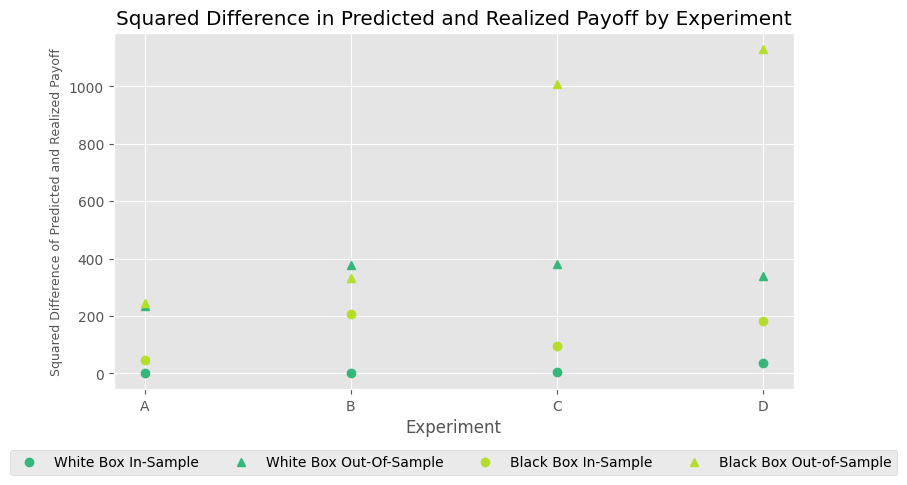

In [18]:
bbPayoffMSE_is = np.mean((bbPredPayoff_is - bbRealPayoff_is)**2, axis=1)
bbPayoffMSE_oos = np.mean((bbPredPayoff_oos - bbRealPayoff_oos)**2, axis=1)
wbPayoffMSE_is = np.mean((wbPredPayoff_is - wbRealPayoff_is)**2, axis=1)
wbPayoffMSE_oos =  np.mean((wbPredPayoff_oos - wbRealPayoff_oos)**2, axis=1)

plt.style.use('ggplot')

# Number of colors you want
n_colors = 10 # just to make match the other plots
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]

plt.figure(figsize=(9, 5))
plt.plot(np.arange(4), wbPayoffMSE_is, 'o', color=colors[6], label="White Box In-Sample")
plt.plot(np.arange(4), wbPayoffMSE_oos, '^', color=colors[6], label="White Box Out-Of-Sample")
plt.plot(np.arange(4), bbPayoffMSE_is, 'o', color=colors[8], label="Black Box In-Sample") # matching colors to other plots
plt.plot(np.arange(4), bbPayoffMSE_oos, '^', color=colors[8], label="Black Box Out-of-Sample")
plt.xticks([0,1,2,3],experimentNames)
plt.xlabel('Experiment')
plt.ylabel('Squared Difference of Predicted and Realized Payoff', fontsize=9)
plt.title('Squared Difference in Predicted and Realized Payoff by Experiment')
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)
plt.tight_layout()



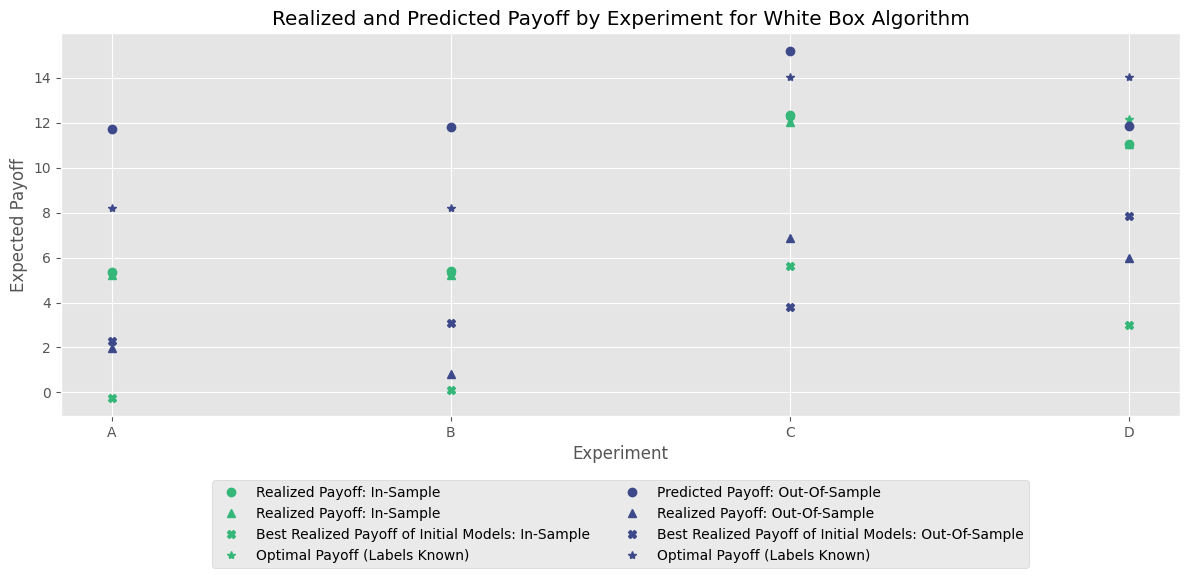

In [61]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10 # just to make match the other plots
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]

plt.figure(figsize=(12, 6))
plt.plot(np.arange(4), np.mean(wbPredPayoff_is, axis=1), 'o', color=colors[6], label="Realized Payoff: In-Sample")
plt.plot(np.arange(4), np.mean(wbRealPayoff_is, axis=1), '^', color=colors[6], label="Realized Payoff: In-Sample")
plt.plot(np.arange(4), max_init_is, "X", color=colors[6], label="Best Realized Payoff of Initial Models: In-Sample")
plt.plot(np.arange(4), best_is, "*", color=colors[6], label="Optimal Payoff (Labels Known)")
plt.plot(np.arange(4), np.mean(wbPredPayoff_oos, axis=1), 'o', color=colors[2], label="Predicted Payoff: Out-Of-Sample")
plt.plot(np.arange(4), np.mean(wbRealPayoff_oos, axis=1), '^', color=colors[2], label="Realized Payoff: Out-Of-Sample")
plt.plot(np.arange(4), max_init_oos,"X", color=colors[2], label="Best Realized Payoff of Initial Models: Out-Of-Sample")
plt.plot(np.arange(4), best_oos, "*", color=colors[2], label="Optimal Payoff (Labels Known)")
plt.legend()
plt.xticks([0,1,2,3],experimentNames)
plt.xlabel('Experiment')
plt.ylabel('Expected Payoff')
plt.title('Realized and Predicted Payoff by Experiment for White Box Algorithm')
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.tight_layout()

plt.savefig('paper-figs/oos-vs-is-WB.pdf')

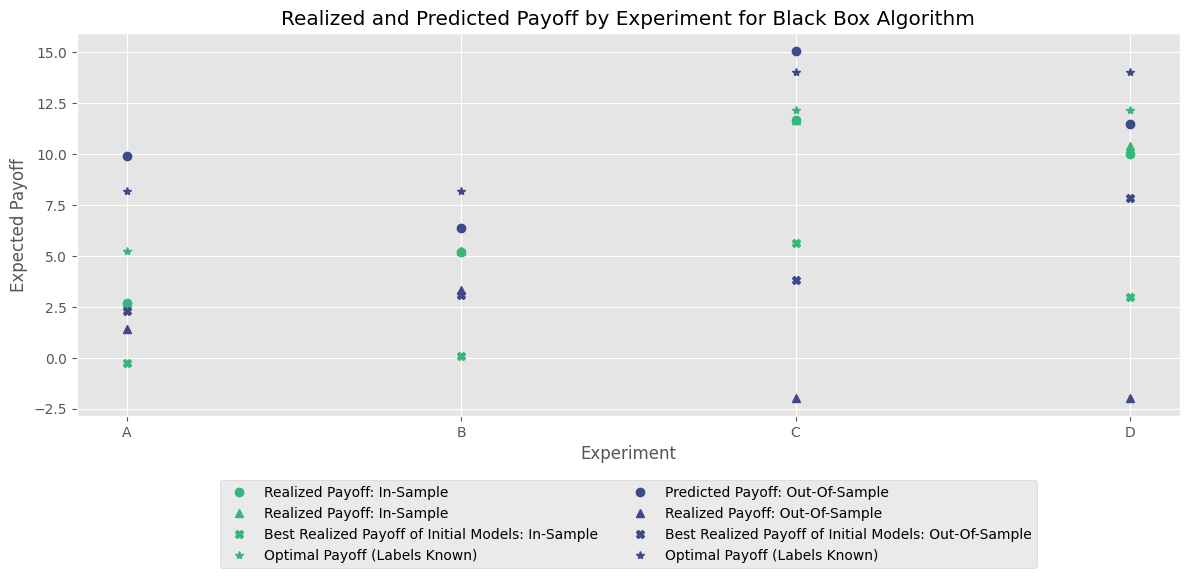

In [60]:
plt.style.use('ggplot')

# Number of colors you want
n_colors = 10 # just to make match the other plots
# Choose a colormap
colormap = plt.get_cmap('viridis')
# Generate colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, n_colors)]

plt.figure(figsize=(12, 6))
plt.plot(np.arange(4), np.mean(bbPredPayoff_is, axis=1), 'o', color=colors[6], label="Realized Payoff: In-Sample")
plt.plot(np.arange(4), np.mean(bbRealPayoff_is, axis=1), '^', color=colors[6], label="Realized Payoff: In-Sample")
plt.plot(np.arange(4), max_init_is, "X", color=colors[6], label="Best Realized Payoff of Initial Models: In-Sample")
plt.plot(np.arange(4), best_is, "*", color=colors[6], label="Optimal Payoff (Labels Known)")
plt.plot(np.arange(4), np.mean(bbPredPayoff_oos, axis=1), 'o', color=colors[2], label="Predicted Payoff: Out-Of-Sample")
plt.plot(np.arange(4), np.mean(bbRealPayoff_oos, axis=1), '^', color=colors[2], label="Realized Payoff: Out-Of-Sample")
plt.plot(np.arange(4), max_init_oos,"X", color=colors[2], label="Best Realized Payoff of Initial Models: Out-Of-Sample")
plt.plot(np.arange(4), best_oos, "*", color=colors[2], label="Optimal Payoff (Labels Known)")
plt.legend()
plt.xticks([0,1,2,3],experimentNames)
plt.xlabel('Experiment')
plt.ylabel('Expected Payoff')
plt.title('Realized and Predicted Payoff by Experiment for Black Box Algorithm')
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
plt.tight_layout()

plt.savefig('paper-figs/oos-vs-is-BB.pdf')
